In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def is_smaller_eps(coord_oa, axis, pois, eps, gl_bounds):
    # coord_oa: float in [0, 1] - coord in other axis
    # axis: 'x' or 'y'
    other_axis = 'x' if axis == 'y' else 'y'
    pois_oa = pois[other_axis]
    ind_st = np.searchsorted(pois_oa[pois_oa['type'] == 0]['coord'], coord_oa, side='right')
    squares_started = pois_oa[pois_oa['type'] == 0][:ind_st]['square_id']
    ind_end = np.searchsorted(pois_oa[pois_oa['type'] == 1]['coord'], coord_oa, side='left')
    squares_ended = pois_oa[pois_oa['type'] == 1][ind_end:]['square_id']
    squares_inter = np.intersect1d(squares_started, squares_ended)

    rel_pois = pois[axis][np.isin(pois[axis]['square_id'], squares_inter)] # relevant points

    min_empty, max_empty = -1, -1
    cnt_segments = 0
    # if there are no squares at coord height/width
    if rel_pois.size == 0:
        return False # bounds[axis][1] - bounds[axis][0] < eps[axis]
    if rel_pois[0]['coord'] > 0:
        min_empty = gl_bounds[axis][0] # 0
    if rel_pois[-1]['coord'] < 1:
        max_empty = gl_bounds[axis][1] # 1
    if min_empty != -1 and max_empty != -1:
        return False # bounds[axis][1] - bounds[axis][0] < eps[axis]
    for rel_poi in rel_pois:
        if min_empty != -1 and max_empty != -1 and (max_empty - min_empty) >= eps[axis]:
            return False
        if rel_poi['type'] == 0:
            cnt_segments += 1
        else:
            cnt_segments -= 1
        if min_empty == -1 and cnt_segments == 0:
            min_empty = rel_poi['coord']
        if max_empty == -1 and cnt_segments == 1 and rel_poi['type'] == 0 and rel_poi['coord'] > gl_bounds[axis][0]: # 0
            max_empty = rel_poi['coord']

    if max_empty == -1:
        return False
    return (max_empty - min_empty) < eps[axis]

In [ ]:
def remove_impossible_areas(axis, remove_small, squares, pois, true_coords, eps, gl_bounds):
    other_axis = 'x' if axis == 'y' else 'y'
    small_areas = []
    big_areas = []
    small_area_st = -1
    big_area_st = -1
    last_coord = -1
    for poi_oa_coord in [gl_bounds[other_axis][0]] + pois[other_axis]['coord'].tolist():
        if is_smaller_eps(poi_oa_coord, axis, pois, eps, gl_bounds):
            if small_area_st == -1:
                small_area_st = poi_oa_coord
            if big_area_st != -1:
                big_areas.append[[big_area_st, poi_oa_coord]]
                big_area_st = -1
        else:
            if small_area_st != -1:
                small_areas.append([small_area_st, last_coord])
                small_area_st = -1
            if big_area_st == -1:
                big_area_st = last_coord if last_coord != -1 else poi_oa_coord
        last_coord = poi_oa_coord
    if small_area_st != -1:
        small_areas.append([small_area_st, gl_bounds[other_axis][1]])
    elif big_area_st != -1:
        big_areas.append([big_area_st, gl_bounds[other_axis][1]])

    areas = small_areas if remove_small else big_areas
    for area in areas:
        bounds = gl_bounds[axis]
        bounds_oa = area
        new_square = bounds + bounds_oa if axis == 'x' else bounds_oa + bounds
        squares = np.append(squares, [new_square], axis=0)
        # insert new pois
        poi_st = (gl_bounds[axis][0], 0, len(squares) - 1)
        poi_end = (gl_bounds[axis][1], 1, len(squares) - 1)
        poi_oa_st = (area[0], 0, len(squares) - 1)
        poi_oa_end = (area[1], 1, len(squares) - 1)
        pois[axis] = np.insert(pois[axis], [0, len(pois[axis])], [poi_st, poi_end], axis=0)
        ind_st = np.searchsorted(pois[other_axis]['coord'], poi_oa_st[0], side='left')
        pois[other_axis] = np.insert(pois[other_axis], ind_st, poi_oa_st, axis=0)
        ind_end = np.searchsorted(pois[other_axis]['coord'], poi_oa_end[0], side='right')
        pois[other_axis] = np.insert(pois[other_axis], ind_end, poi_oa_end, axis=0)
    return squares, pois

In [ ]:
def run_process(eps, gl_bounds, true_coords, squares):
    dtype = [('coord', np.float64), ('type', np.int8), ('square_id', np.int64)]

    # points of interest
    pois_x = np.concatenate([np.array(list(zip(squares[:, 0], [0] * len(squares), np.arange(len(squares)))), dtype=dtype),
                            np.array(list(zip(squares[:, 1], [1] * len(squares), np.arange(len(squares)))), dtype=dtype)])
    pois_x = pois_x[np.argsort(pois_x, order=('coord', 'type'))]

    pois_y = np.concatenate([np.array(list(zip(squares[:, 2], [0] * len(squares), np.arange(len(squares)))), dtype=dtype),
                            np.array(list(zip(squares[:, 3], [1] * len(squares), np.arange(len(squares)))), dtype=dtype)])
    pois_y = pois_y[np.argsort(pois_y, order=('coord', 'type'))]

    pois = {'x': pois_x, 'y': pois_y}

    nrows, ncols = 2, 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 12))

    axis = 'x'
    does_know = {'x': False, 'y': False}

    ax_i = 0
    ax_j = 0
    for i in range(nrows * ncols):
        if does_know['x'] and does_know['y']:
            break
        draw(fig, axs[ax_i, ax_j], squares, true_coords, gl_bounds)
        ax_j = (ax_j + 1) % ncols
        if ax_j == 0:
            ax_i += 1
        other_axis = 'x' if axis == 'y' else 'y'
        if is_smaller_eps(true_coords[other_axis], axis, pois, eps, gl_bounds):
            print(axis, "knows")
            does_know[axis] = True
            squares, pois = remove_impossible_areas(axis, False, squares, pois, true_coords, eps, gl_bounds)
        else:
            print(axis, "doesn't know")
            squares, pois = remove_impossible_areas(axis, True, squares, pois, true_coords, eps, gl_bounds)
        axis = other_axis

    plt.show()

In [ ]:
eps = {'x': 0.4, 'y': 0.4}
gl_bounds = {'x': [0, 1], 'y': [0, 1]} # global bounds
true_coords = {'x': 0.6, 'y': 0.4}

# store squares as [x_min, x_max, y_min, y_max]
squares = np.array([[0, 0.5, 0, 0.5],
                    [0, 1, 0.75, 1],
                    [0.8, 1, 0, 0.2]])

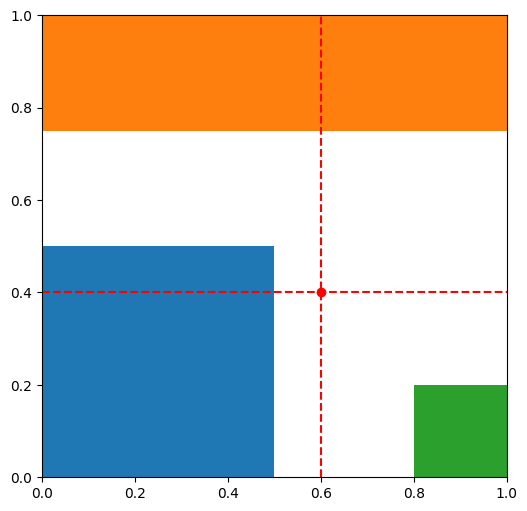

In [ ]:
# square 1 x 1
def draw(fig, ax, squares, true_coords, gl_bounds):
    for square in squares:
        x = [square[0], square[0], square[1], square[1]]
        y = [square[2], square[3], square[3], square[2]]
        ax.fill(x, y)
    ax.plot(true_coords['x'], true_coords['y'], marker='o', color='red')
    ax.vlines(true_coords['x'], 0, 1, colors='red', linestyle='dashed')
    ax.hlines(true_coords['y'], 0, 1, colors='red', linestyle='dashed')

    ax.set(xlim=gl_bounds['x'], ylim=gl_bounds['y'])


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
draw(fig, ax, squares, true_coords, gl_bounds)

x doesn't know
y doesn't know
x doesn't know
y doesn't know


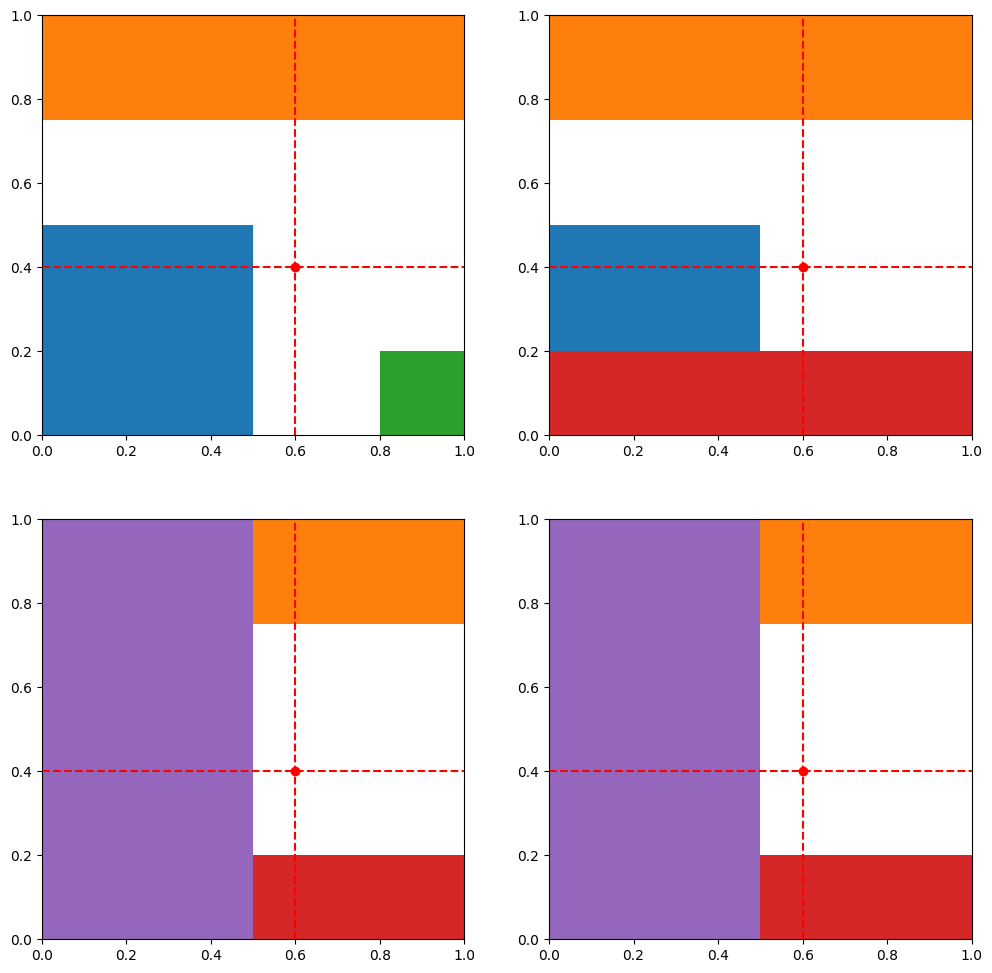

In [ ]:
run_process(eps, gl_bounds, true_coords, squares)

x knows
y knows


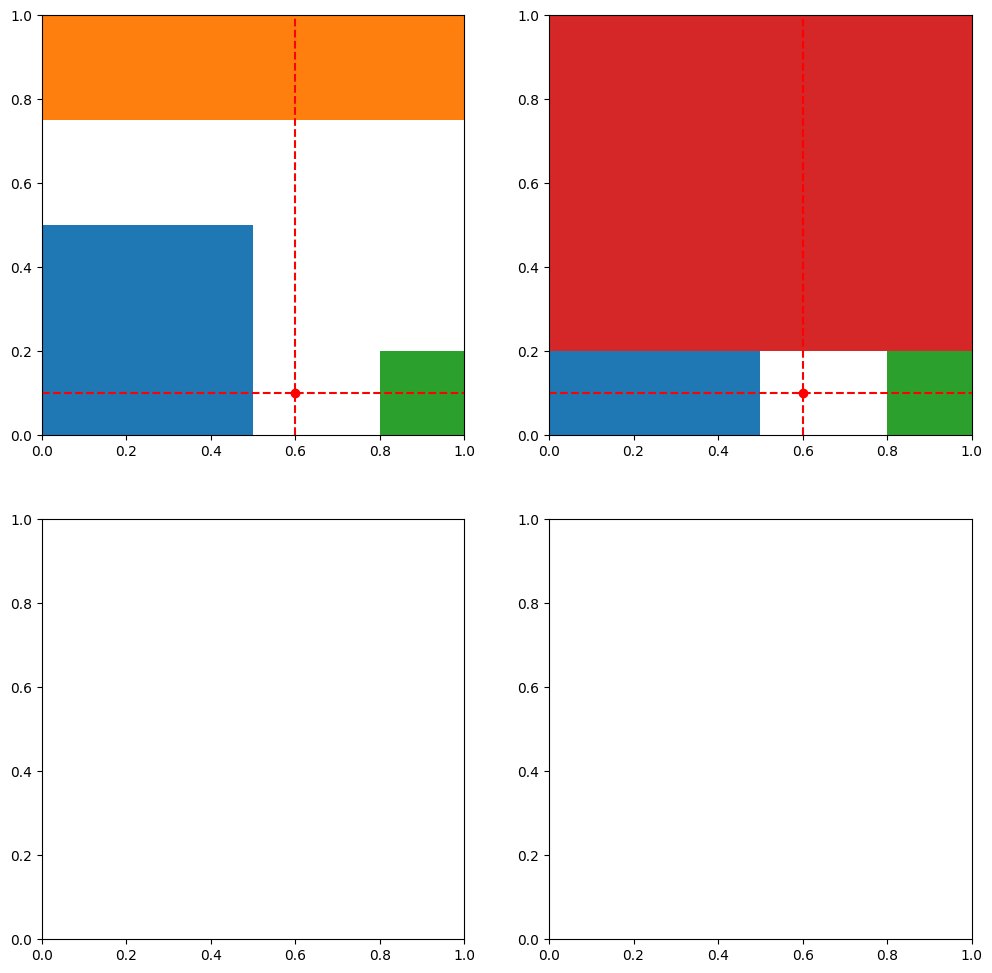

In [ ]:
true_coords = {'x': 0.6, 'y': 0.1}

run_process(eps, gl_bounds, true_coords, squares)